In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

### Scipy Fast Fourier Transform Demo

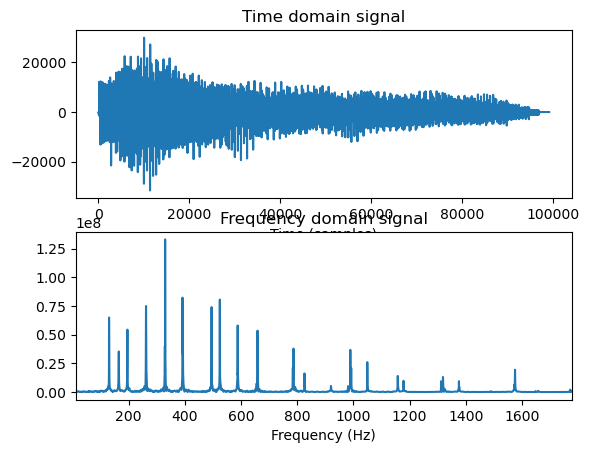

In [3]:
# Load the WAV file
rate, data = wavfile.read('Audio_Files\Major\Major_0.wav')

# Get the length of the audio data
n = len(data)

# Calculate the FFT of the audio data
fft_data = fft(data)

# Calculate the frequency range of the FFT
freqs = fftfreq(n, 1/rate)

# Find the indices of the maximum values in the FFT
max_indices = np.argmax(np.abs(fft_data))

# Zoom in on the area of spikes in the frequency domain plot
# The fundamental frequencies for the notes on a piano range from 27.5 Hz to 4186 Hz
start_index = 27
end_index = 4000
freqs = freqs[start_index:end_index]
fft_data = fft_data[start_index:end_index]

# Plot the time domain and frequency domain signals
plt.subplot(2, 1, 1)
plt.plot(data)
plt.xlabel('Time (samples)')
plt.title('Time domain signal')

plt.subplot(2, 1, 2)
plt.plot(freqs, np.abs(fft_data))
plt.xlabel('Frequency (Hz)')
plt.title('Frequency domain signal')
plt.xlim(freqs[0], freqs[-1])

plt.show()

In [4]:
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

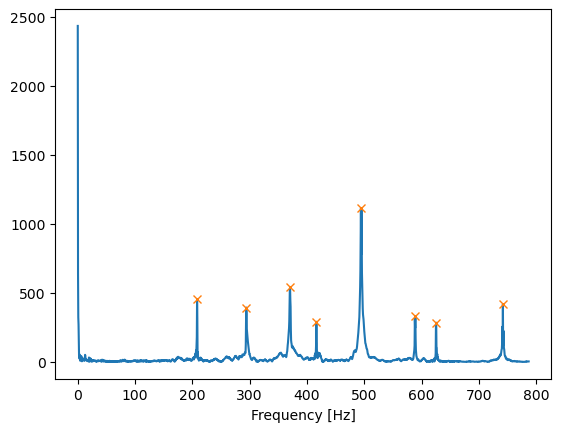

Harmonics: [208. 294. 370. 416. 494. 589. 625. 742.]


In [5]:
path = "Audio_Files\Minor\Minor_169.wav"

harmonics_2 = find_harmonics(path, print_peaks=True)
print("Harmonics: {}".format(np.round(harmonics_2)))

### Build training task

In [6]:
path = "Audio_Files"
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename == '.DS_Store':
            continue
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        cur_data = [foldername, filename]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)

In [7]:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df["Chord Type"].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

### Generating Intervals

1. All in between intervalls

In [9]:
df_original = df.copy() # refreshing df
df = df_original.copy()

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,1.049688,1.197417,1.061102,1.103298,1.017656,1.113492,1.005082,1.043128,1.145029,1.166709
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,1.125534,1.111533,1.008802,1.389790,1.080752,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,1.054971,1.063154,1.176470,1.011280,1.055261,1.124936,1.053495,1.124803,1.067888,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,1.113791,1.007590,1.064304,1.119760,1.122995,1.039390,1.019581,1.059233,1.059000,1.102333
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,1.188654,1.191808,1.060464,1.057780,1.251999,1.069225,1.120785,1.124279,1.038861,NaN


2. Intervals between the first harmonic and the rest

In [10]:
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)

In [11]:
# importing packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4"]
columns.extend(["Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.40, random_state=0)

train_X.head()

,Interval 1,Interval 2,Interval 3,Interval 4,Interval 4_1,Interval 5_1,Interval 6_1
585,1.793936,1.119604,1.188029,1.262596,2.386153,3.012746,3.579278
403,1.266029,1.416978,1.119604,1.121779,2.008497,2.253090,2.527810
532,1.788230,1.063333,1.051867,1.029531,2.000108,2.059174,2.389184
104,1.252365,1.332132,1.198879,1.121500,2.000107,2.243121,2.514187
303,1.389736,1.019817,1.093394,1.024923,1.549642,1.588264,2.000040


In [13]:
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

score_knn = cross_val_score(knn, train_X, train_y, cv=10).mean()
score_dtc = cross_val_score(dtc, train_X, train_y, cv=10).mean()
score_rfc = cross_val_score(rfc, train_X, train_y, cv=10).mean()

In [14]:
print("Cross Val Score for KNeighbors Classifier: {:.2f}".format(score_knn))
print("Cross Val Score for Decision Tree Classifier: {:.2f}".format(score_dtc))
print("Cross Val Score for Random Forest Classifier: {:.2f}".format(score_rfc))

Cross Val Score for KNeighbors Classifier: 0.83
Cross Val Score for Decision Tree Classifier: 0.90
Cross Val Score for Random Forest Classifier: 0.91


In [15]:
def plot_confusion_matrix(val_y, pred_y):
    # Generate cm
    cm = confusion_matrix(val_y, pred_y)
    acc = accuracy_score(val_y, pred_y)

    # Plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Reds')
    ax.set_xticks(np.arange(len(np.unique(val_y))))
    ax.set_yticks(np.arange(len(np.unique(val_y))))
    ax.set_xticklabels(['Minor', 'Major'])
    ax.set_yticklabels(['Minor', 'Major'])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    for i in range(len(np.unique(val_y))):
        for j in range(len(np.unique(val_y))):
            text = ax.text(j, i, cm[i, j],
                        ha='center', va='center', color='black')
    print("Accuracy: {:.2f}".format(acc))

### Random Forest

Accuracy: 0.92


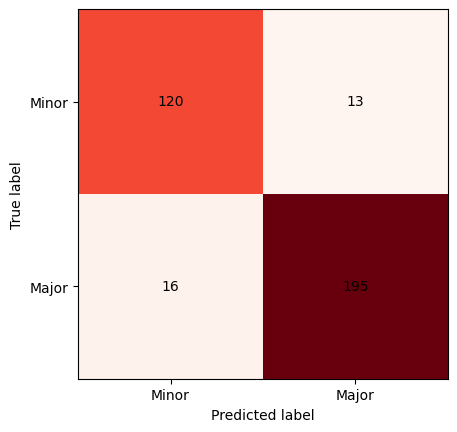

In [16]:
classifier = RandomForestClassifier(random_state=0)

classifier.fit(train_X, train_y)
pred_y = classifier.predict(val_X)

plot_confusion_matrix(val_y, pred_y)

Accuracy: 0.83


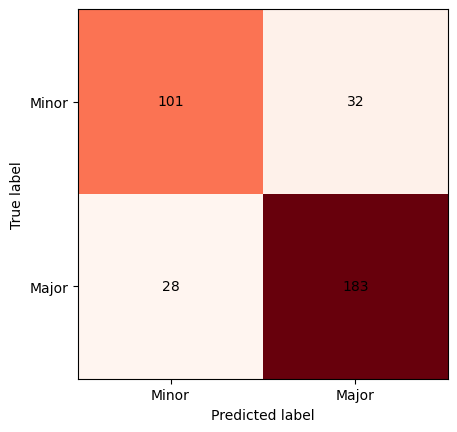

In [18]:
classifier = knn = KNeighborsClassifier()

classifier.fit(train_X, train_y)
pred_y = classifier.predict(val_X)

plot_confusion_matrix(val_y, pred_y)